## Load Data From Kaggle

In [ ]:
! mkdir ~/.kaggle

In [25]:
! cp kaggle.json kaggle

In [25]:
! chmod 600 ~/.kaggle/kaggle.json

## Download Data

In [25]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

In [ ]:
! kaggle datasets download alexako/unet-weights

## Extract Dataset

In [ ]:
import zipfile
with zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('skin')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/unet-weights.zip', 'r') as zip_ref:
    zip_ref.extractall('unet')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, UpSampling2D, Input, Reshape

from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [ ]:
base_skin_dir = os.path.join('..', '/content/skin')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.tail()

lesion_id      image_id     dx dx_type   age     sex localization  \
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                    path          cell_type  \
10010  /kaggle/input/skin-cancer-mnist-ham10000/ham10...  Actinic keratoses   
10011  /kaggle/input/skin-cancer-mnist-ham10000/ham10...  Actinic keratoses   
10012  /kaggle/input/skin-cancer-mnist-ham10000/ham10...  Actinic keratoses   
10013  /kaggle/input/skin-cancer-mnist-ham10000/ham10...  Actinic keratoses   
10014  /kaggle/input/skin-cancer-mnist-ham10000/ham10...           Melanoma   

       cell_type_idx  
10010              0  
10011              0  
10012              0  
10013              0  
10014              5

In [ ]:
print(skin_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')


In [ ]:
skin_df.head(3)

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2

In [ ]:
skin_df['age'].fillna(int(skin_df['age'].mean()),inplace=True)

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

**Distrubtion of the 7 different classes**

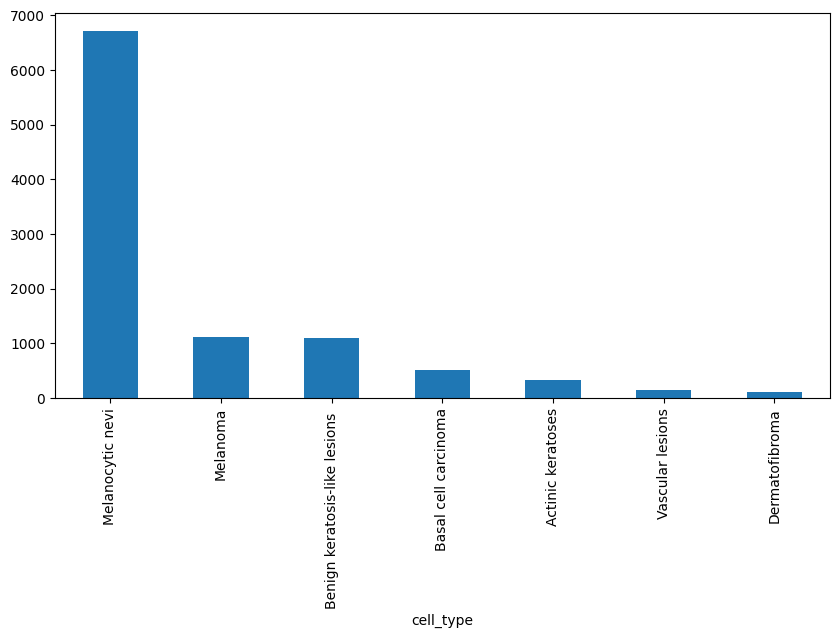

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

# Save the plot as a PNG file
plt.savefig('Cell_Type_Counts.png')

plt.show()


In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


# Show first Five Items in Dictionary
for i, (image_id, file_path) in enumerate(imageid_path_dict.items()):
    print(f"{image_id}: {file_path}")
    if i == 4:  # Stop after printing the first five pairs
        break

ISIC_0028933: ../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028933.jpg
ISIC_0028394: ../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028394.jpg
ISIC_0027799: ../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027799.jpg
ISIC_0028100: ../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028100.jpg
ISIC_0027960: ../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027960.jpg


In [ ]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
1  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
2  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
3  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
4  ../input/skin-cancer-mnist-ham10000/ham10000_i...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

****Images processing****

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

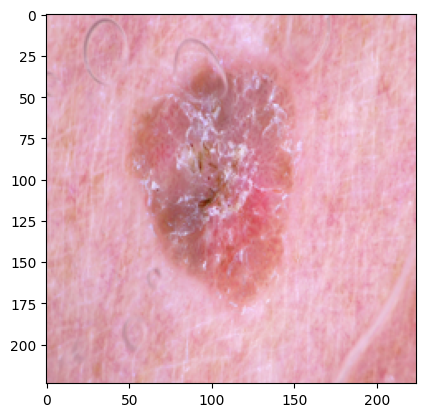

In [ ]:
plt.imshow(skin_df['image'][9])
plt.show()

<Axes: xlabel='dx_type'>

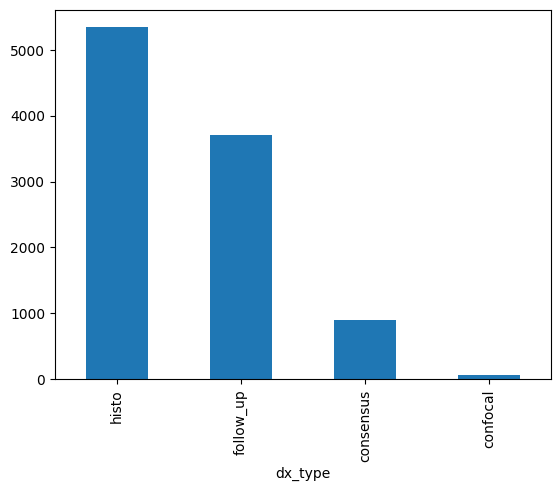

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

**Distribution of localized field**

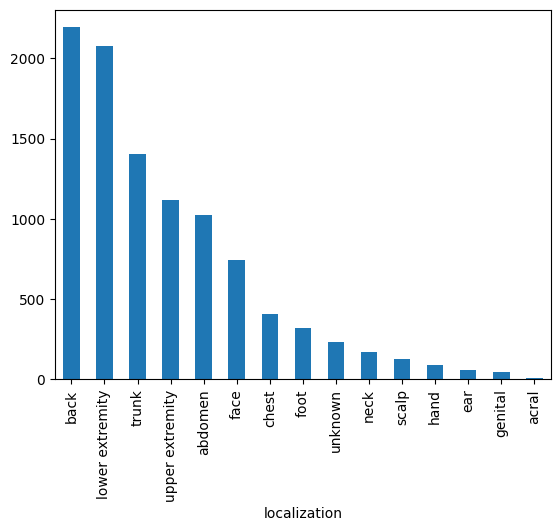

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')
plt.savefig('localization.png')

**Distribution of age**

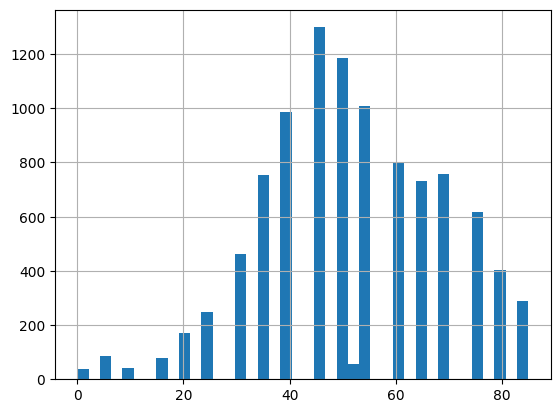

In [ ]:
skin_df['age'].hist(bins=40)
plt.savefig('Distribution of Age')

**Distribution of Gender**

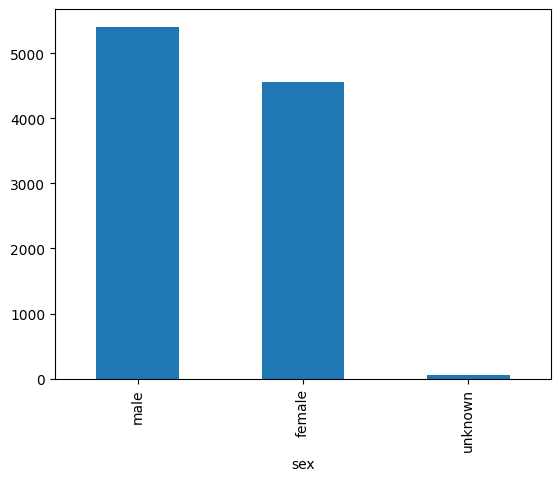

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')
plt.savefig('Distribution_of_gender.png')

**Distribution of age and cancer type**

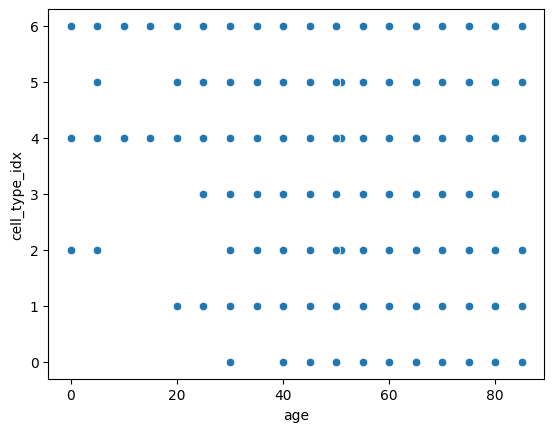

In [ ]:
sns.scatterplot(x='age', y='cell_type_idx', data=skin_df)
plt.savefig('distribution_age_cancer_type.png')

**Display sample images of each cancer type**

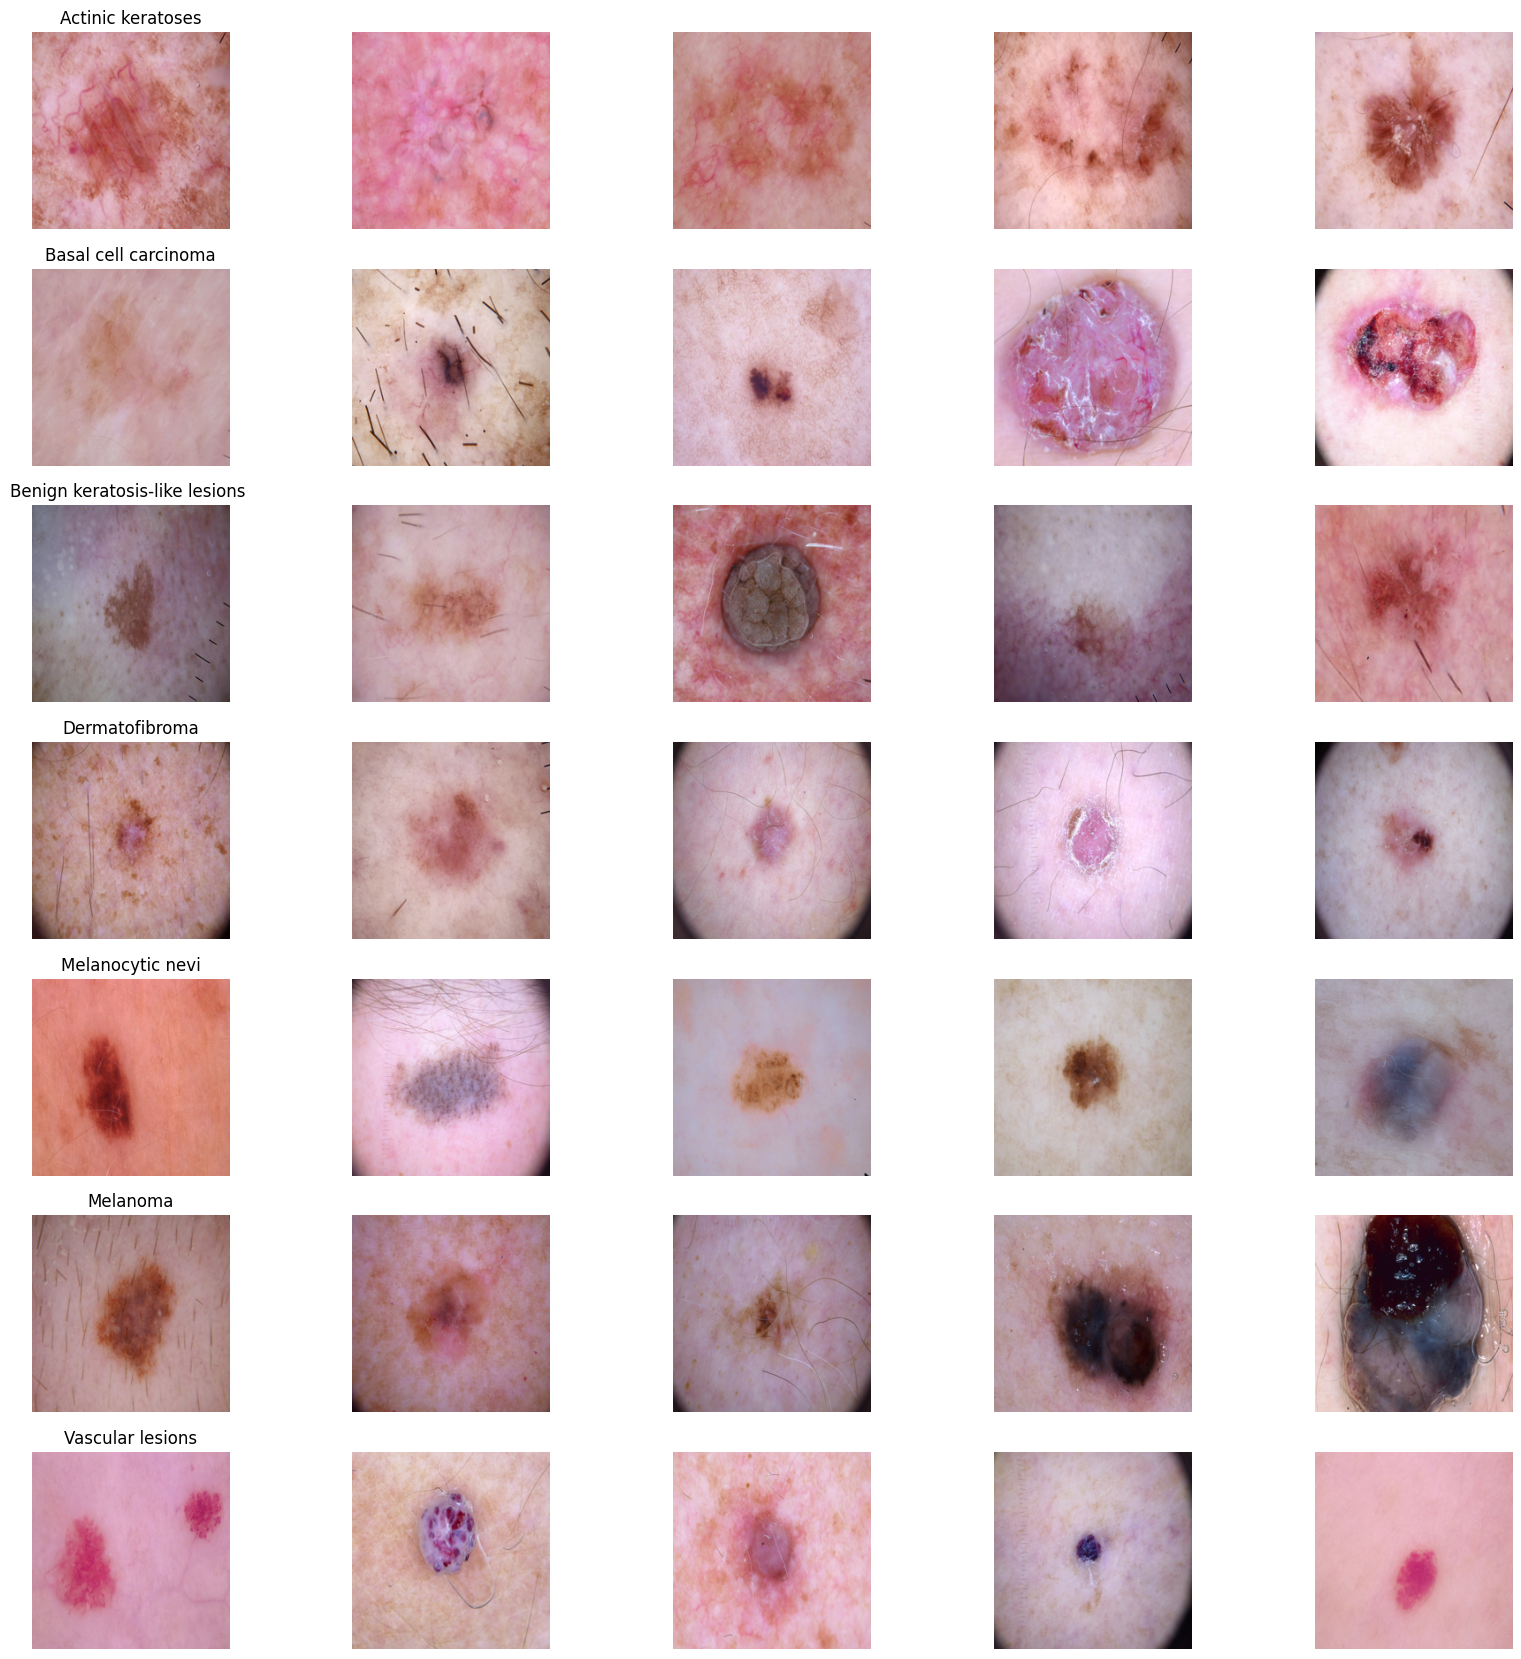

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(224, 224, 3)    10015
Name: count, dtype: int64

**set target and features**

In [ ]:
skin_df= skin_df[skin_df['age'] != 0]
skin_df= skin_df[skin_df['sex'] != 'unknown']

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

**Split training set**

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.30,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Melanoma', b'Dermatofibroma',
       b'Benign keratosis-like lesions ', b'Actinic keratoses',
       b'Vascular lesions', b'Basal cell carcinoma'], dtype=object)>, idx=<tf.Tensor: shape=(6944,), dtype=int32, numpy=array([0, 0, 0, ..., 6, 0, 0], dtype=int32)>)

**Normalization**

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [ ]:
print(x_train.shape)
print(x_test.shape)

(6944, 224, 224, 3)
(2977, 224, 224, 3)


In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
print(y_train.shape)
print(y_test.shape)


(6944, 7)
(2977, 7)


**Label encoding**

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**Spliting traning and validation**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

**Reshape images into 3 dimension**

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

In [ ]:
print(np.bincount(skin_df['cell_type_idx']))

[ 327  514 1084  115 6630 1113  138]


**Load U-Net model**

In [ ]:
def unet():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)

    pred = Reshape((224, 224))(x)
    model = Model(inputs=img_input, outputs=pred)
    model.load_weights('/kaggle/input/unet-weights/unet_100_epoch.h5')

    return model

unet_model = unet()

**Helper method**

In [ ]:
def enhance(img):
    sub = (unet_model.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [ ]:
import cv2

def applyMask(img):
    mask = np.array(enhance(img).reshape(224, 224), dtype=np.uint8)

    res = cv2.bitwise_and(img,img,mask = mask)

    return res

**Apply mask**

In [ ]:
random_sample_df = skin_df.sample(n=5)
print(random_sample_df['cell_type'].value_counts())

img_list = [img for img in random_sample_df['image']]

seg_img_list = [applyMask(img) for img in img_list]

cell_type
Melanocytic nevi                  3
Melanoma                          1
Benign keratosis-like lesions     1
Name: count, dtype: int64
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


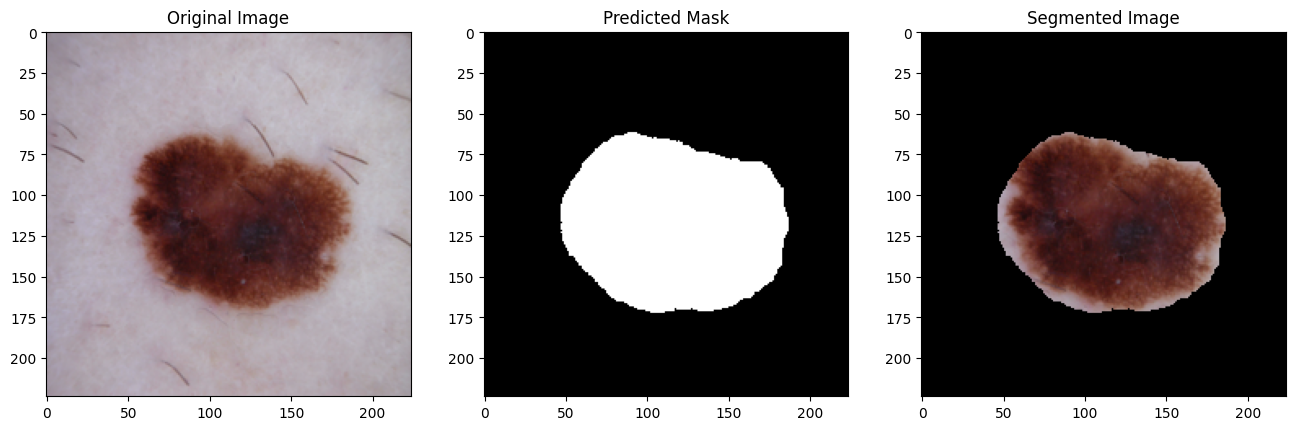

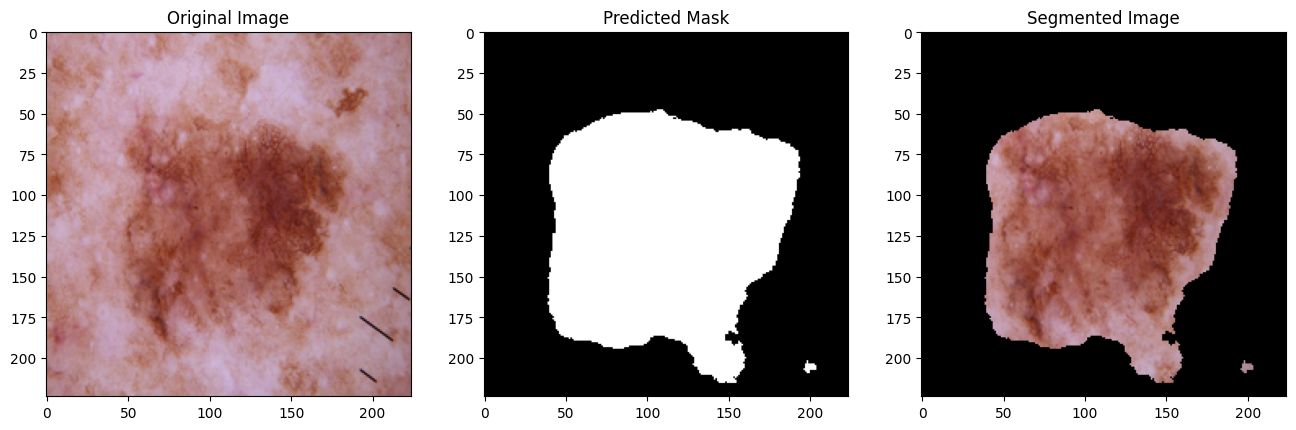

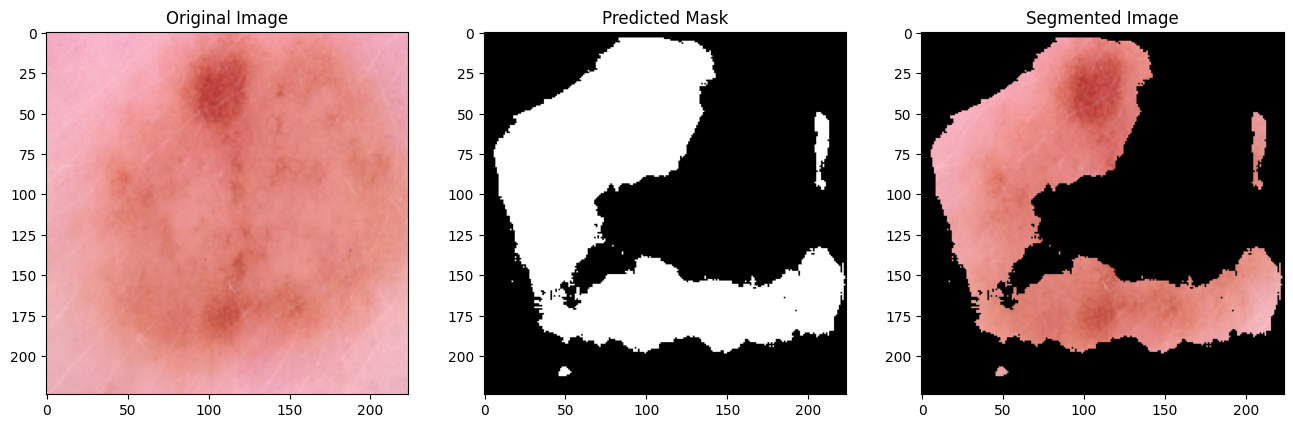

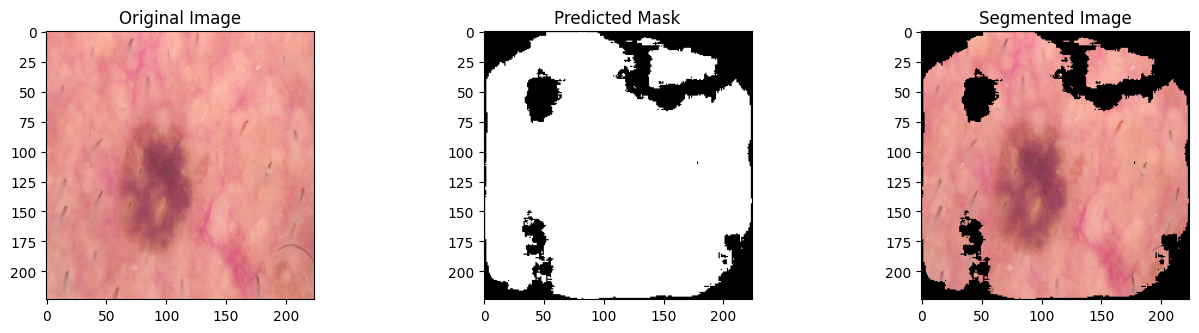

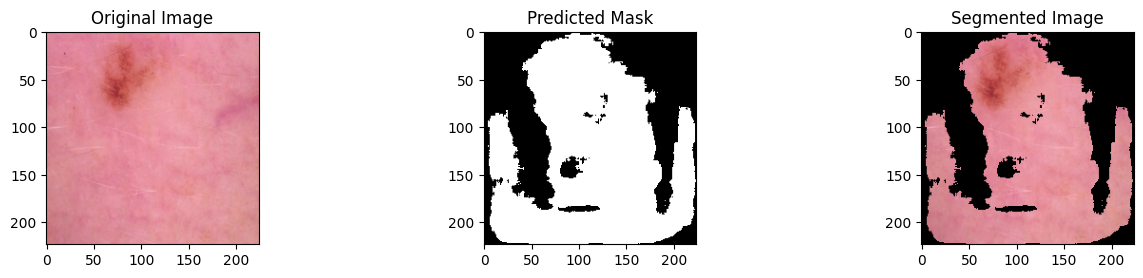

In [ ]:
def show_comparison(img_list):
    for i in range(len(img_list)):
        plt.figure(figsize=(16,16))
        plt.subplot(i+1,3,1)
        plt.imshow(img_list[i])
        plt.title('Original Image')
        plt.subplot(i+1,3,2)
        plt.imshow(enhance(img_list[i]).reshape(224, 224), plt.cm.binary_r)
        plt.title('Predicted Mask')
        plt.subplot(i+1,3,3)
        plt.imshow(applyMask(img_list[i]), plt.cm.binary_r)
        plt.title('Segmented Image')
        plt.savefig('segmented_images.png')

show_comparison(img_list)

## Create Dataset

In [ ]:
output_base_dir = 'Skin_disease_segment_latest_dataset'
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)

In [ ]:
def enhance(img_array):
    prediction = unet_model.predict(img_array.reshape(1,224,224,3))
    mask = (prediction.flatten() > 0.5).astype(np.uint8)
    return mask

In [ ]:
def applyMask(img, mask):
    reshaped_mask = mask.reshape(224, 224)
    img_uint8 = img.astype(np.uint8)
    res = cv2.bitwise_and(img_uint8, img_uint8, mask=reshaped_mask)
    return res

In [ ]:
def process_and_save_images(df):
    for index, row in df.iterrows():

        img = row['image']

        mask = enhance(img)

        segmented_img = applyMask(img, mask)

        segmented_img_pil = Image.fromarray(segmented_img)

        cell_type_dir = os.path.join(output_base_dir, row['cell_type'])
        if not os.path.exists(cell_type_dir):
            os.makedirs(cell_type_dir)

        save_path = os.path.join(cell_type_dir, row['image_id'] + '.png')

        segmented_img_pil.save(save_path)

In [ ]:
process_and_save_images(skin_df)

# **Skin Images Classification code**

In [1]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers, models
import os
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Latest skin dataset")

In [6]:
data_path="/content/drive/MyDrive/Latest skin dataset"

In [7]:
names=os.listdir(data_path)
names

['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions ',
 'Dermatofibroma',
 'Melanocytic nevi',
 'Melanoma',
 'Vascular lesions']

In [8]:
count=0
for name in names:
    size=len(os.listdir(os.path.join(data_path, name)))
    print(size, name)

327 Actinic keratoses
514 Basal cell carcinoma
1084 Benign keratosis-like lesions 
115 Dermatofibroma
6630 Melanocytic nevi
1113 Melanoma
138 Vascular lesions


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # fill_mode='nearest',
    # horizontal_flip=True,
    # vertical_flip=True
)

In [19]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [20]:
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    subset='training',
    batch_size=40
)

validation_generator = val_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    subset='validation',
    batch_size=25
)

Found 7940 images belonging to 7 classes.
Found 1981 images belonging to 7 classes.


In [23]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

In [24]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [25]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator
)

Epoch 1/3
199/199 [==============================] - 95s 285ms/step - loss: 0.8294 - accuracy: 0.7053 - val_loss: 1.3710 - val_accuracy: 0.6896
Epoch 2/3
199/199 [==============================] - 56s 280ms/step - loss: 0.6397 - accuracy: 0.7652 - val_loss: 0.8000 - val_accuracy: 0.7279
Epoch 3/3
199/199 [==============================] - 56s 279ms/step - loss: 0.5378 - accuracy: 0.8011 - val_loss: 0.7616 - val_accuracy: 0.7466


In [27]:
model.save("/content/drive/MyDrive/Model skin_disease_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


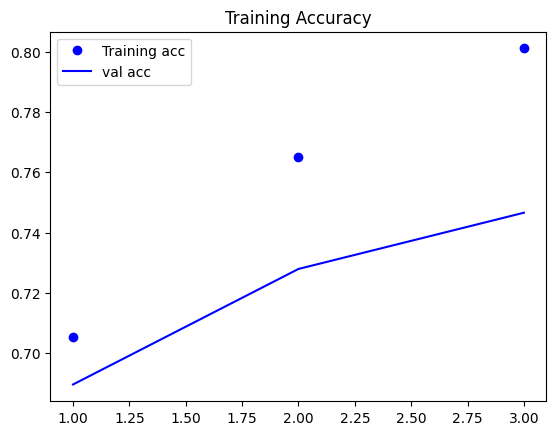

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='val acc')
plt.title('Training Accuracy')
plt.legend()
plt.show()

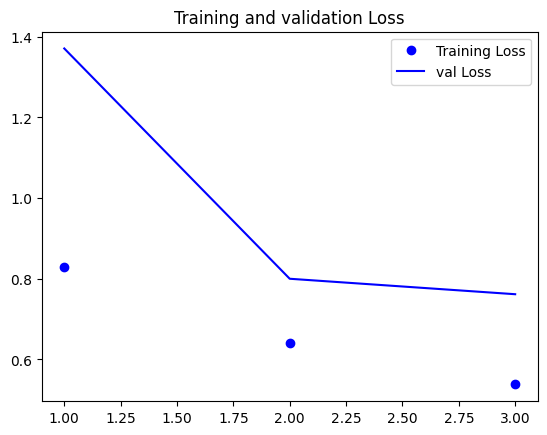

In [29]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="val Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [30]:
loss,acc= model.evaluate(validation_generator)

80/80 [==============================] - 11s 132ms/step - loss: 0.7616 - accuracy: 0.7466


In [31]:
print("Test Data Loss: ",loss)
print("Test Data Accuracy: ",acc)

Test Data Loss:  0.7616199851036072
Test Data Accuracy:  0.74659264087677
